## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

In [ ]:
# dataset_dir = "Path to the dataset"
# print("Loading dataset from: " + dataset_dir)

In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.

Found 20000 files belonging to 2 classes.

Training Classes:

['FAKE', 'REAL']

Testing Classes:

['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [6]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function. 

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [33]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()


94765736/94765736 [==============================] - 1s 0us/step

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 resnet50 (Functional)       (None, 2048)              23587712  

                                                                 

 batch_normalization (BatchN  (None, 2048)             8192      

 ormalization)                                                   

                                                                 

 dense (Dense)               (None, 256)               524544    

                                                                 

 dropout (Dropout)           (None, 256)               0         

                                                                 

 dense_1 (Dense)             (None, 64)      

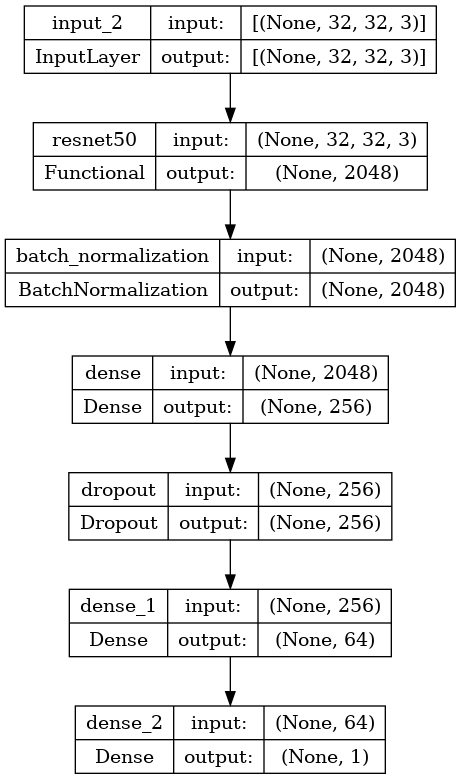

In [34]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [35]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...

Epoch 1/100

200/200 [==============================] - 237s 948ms/step - loss: 2.5975 - accuracy: 0.9034 - precision: 0.8989 - recall: 0.9091 - val_loss: 1.4572 - val_accuracy: 0.6917 - val_precision: 0.9977 - val_recall: 0.3843

Epoch 2/100

200/200 [==============================] - 30s 148ms/step - loss: 0.4608 - accuracy: 0.9414 - precision: 0.9407 - recall: 0.9422 - val_loss: 0.2927 - val_accuracy: 0.9447 - val_precision: 0.9515 - val_recall: 0.9372

Epoch 3/100

200/200 [==============================] - 30s 148ms/step - loss: 0.2200 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - val_loss: 0.3287 - val_accuracy: 0.9000 - val_precision: 0.8375 - val_recall: 0.9924

Epoch 4/100

200/200 [==============================] - 30s 147ms/step - loss: 0.1629 - accuracy: 0.9578 - precision: 0.9592 - recall: 0.9563 - val_loss: 0.1737 - val_accuracy: 0.9491 - val_precision: 0.9400 - val_recall: 0.9594

Epoch 5/100

200/20

In [36]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 94ms/step - loss: 0.1429 - accuracy: 0.9563 - precision: 0.9549 - recall: 0.9577

Val Loss: 0.1429

Val Accuracy: 0.9563

Val Precision: 0.9549

Val Recall: 0.9577


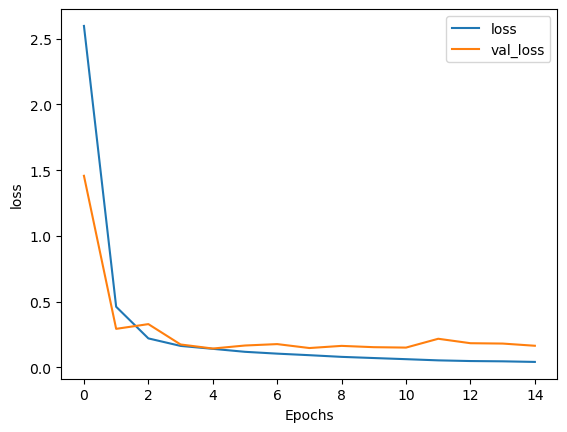

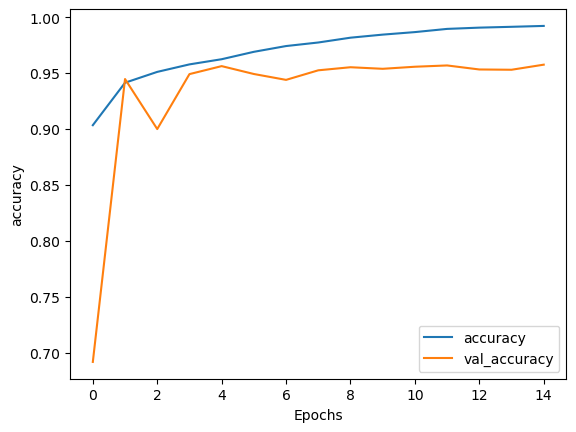

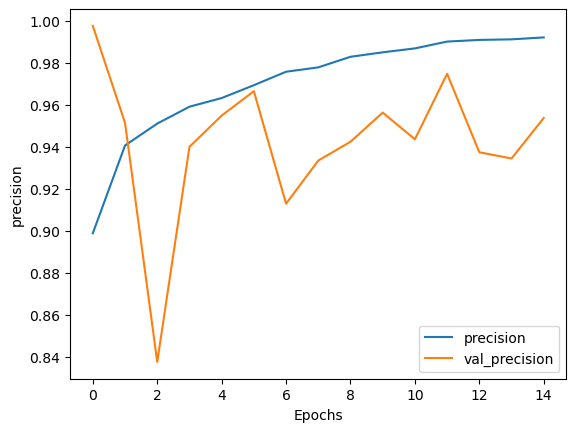

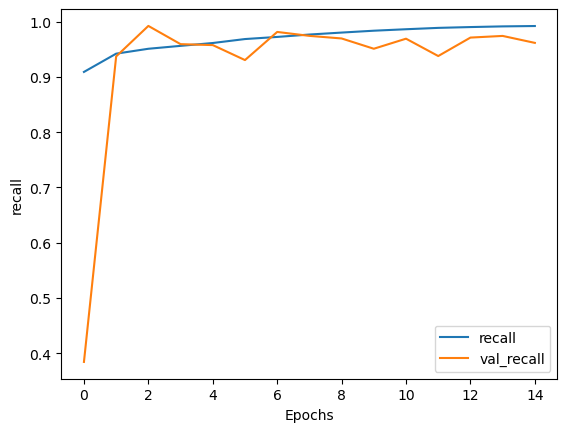

In [37]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

In [42]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()


58889256/58889256 [==============================] - 0s 0us/step

Model: "model_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 vgg16 (Functional)          (None, 512)               14714688  

                                                                 

 batch_normalization_1 (Batc  (None, 512)              2048      

 hNormalization)                                                 

                                                                 

 dense_3 (Dense)             (None, 256)               131328    

                                                                 

 dropout_1 (Dropout)         (None, 256)               0         

                                                                 

 dense_4 (Dense)             (None, 64)    

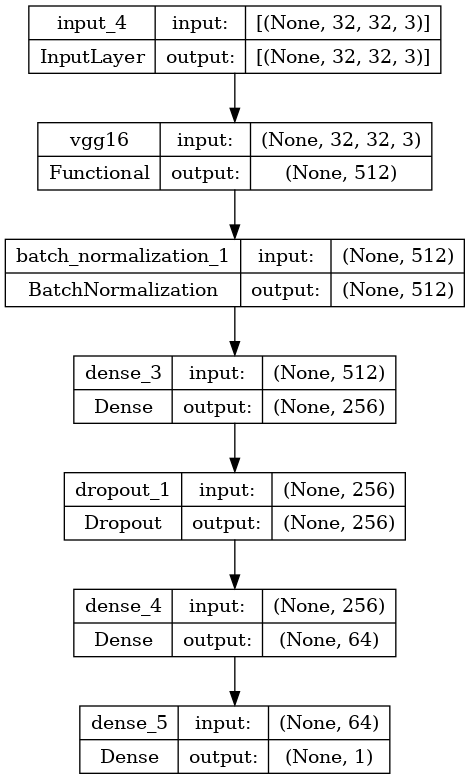

In [43]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [44]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...

Epoch 1/100

200/200 [==============================] - 52s 209ms/step - loss: 1.7993 - accuracy: 0.8617 - precision_1: 0.8493 - recall_1: 0.8794 - val_loss: 0.6146 - val_accuracy: 0.8459 - val_precision_1: 0.9795 - val_recall_1: 0.7066

Epoch 2/100

200/200 [==============================] - 42s 205ms/step - loss: 0.3229 - accuracy: 0.9290 - precision_1: 0.9290 - recall_1: 0.9289 - val_loss: 0.5541 - val_accuracy: 0.8063 - val_precision_1: 0.7219 - val_recall_1: 0.9964

Epoch 3/100

200/200 [==============================] - 42s 205ms/step - loss: 0.2012 - accuracy: 0.9434 - precision_1: 0.9435 - recall_1: 0.9432 - val_loss: 0.1943 - val_accuracy: 0.9357 - val_precision_1: 0.9034 - val_recall_1: 0.9758

Epoch 4/100

200/200 [==============================] - 43s 209ms/step - loss: 0.1577 - accuracy: 0.9550 - precision_1: 0.9536 - recall_1: 0.9565 - val_loss: 0.1782 - val_accuracy: 0.9406 - val_precision_1: 0.9776 - val_recall_1:

In [45]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 95ms/step - loss: 0.1155 - accuracy: 0.9656 - precision_1: 0.9613 - recall_1: 0.9702

Val Loss: 0.1155

Val Accuracy: 0.9656

Val Precision: 0.9613

Val Recall: 0.9702


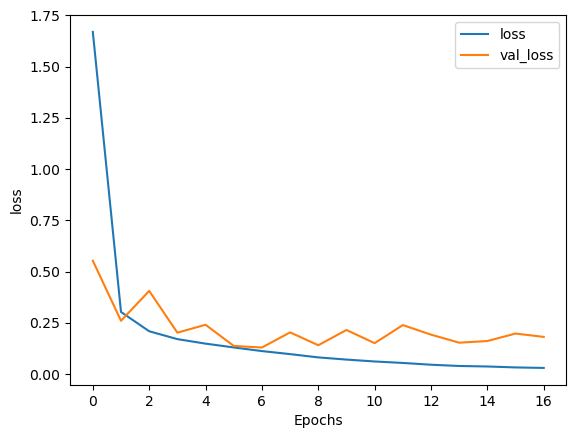

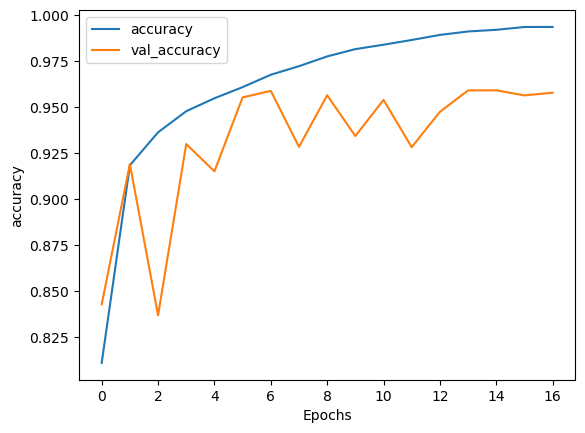

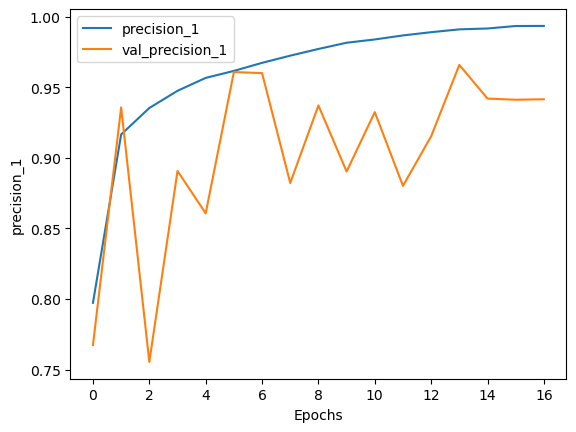

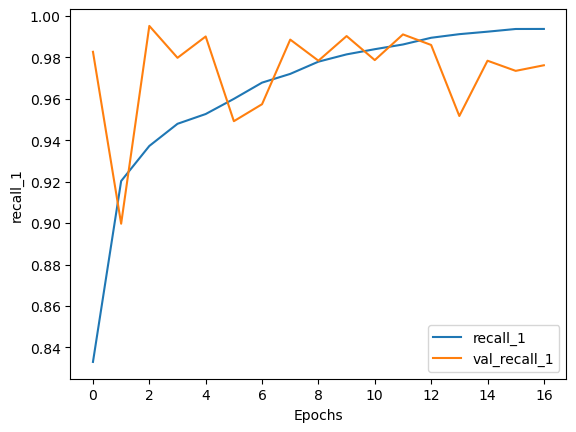

In [46]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

In [48]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()


24274472/24274472 [==============================] - 0s 0us/step

Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 efficientnetv2-b0 (Function  (None, 1280)             5919312   

 al)                                                             

                                                                 

 batch_normalization_2 (Batc  (None, 1280)             5120      

 hNormalization)                                                 

                                                                 

 dense_6 (Dense)             (None, 256)               327936    

                                                                 

 dropout_2 (Dropout)         (None, 256)               0         

                                           

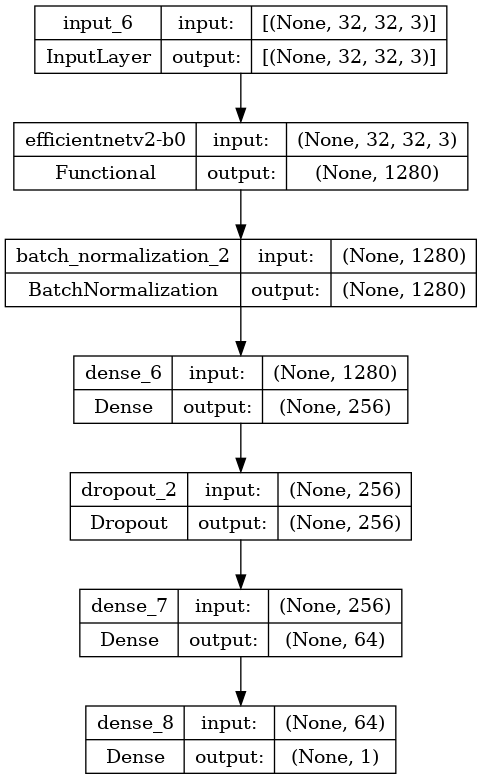

In [49]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [50]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using EfficientNet...

Epoch 1/100

200/200 [==============================] - 167s 542ms/step - loss: 1.7146 - accuracy: 0.9371 - precision: 0.9400 - recall: 0.9339 - val_loss: 0.4656 - val_accuracy: 0.8809 - val_precision: 0.8091 - val_recall: 0.9970

Epoch 2/100

200/200 [==============================] - 53s 261ms/step - loss: 0.1723 - accuracy: 0.9682 - precision: 0.9687 - recall: 0.9676 - val_loss: 0.7011 - val_accuracy: 0.7276 - val_precision: 0.6474 - val_recall: 0.9999

Epoch 3/100

200/200 [==============================] - 55s 267ms/step - loss: 0.1045 - accuracy: 0.9778 - precision: 0.9783 - recall: 0.9773 - val_loss: 0.1641 - val_accuracy: 0.9473 - val_precision: 0.9096 - val_recall: 0.9933

Epoch 4/100

200/200 [==============================] - 54s 266ms/step - loss: 0.0780 - accuracy: 0.9845 - precision: 0.9851 - recall: 0.9839 - val_loss: 0.1122 - val_accuracy: 0.9696 - val_precision: 0.9799 - val_recall: 0.9588

Epoch 5/100

20

In [51]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 102ms/step - loss: 0.1034 - accuracy: 0.9729 - precision_2: 0.9764 - recall_2: 0.9693

Val Loss: 0.1034

Val Accuracy: 0.9729

Val Precision: 0.9764

Val Recall: 0.9693


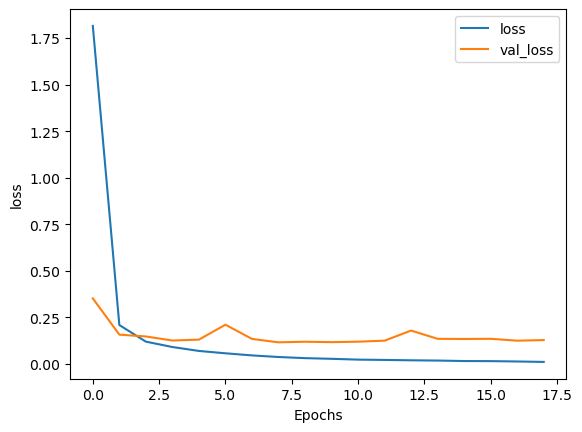

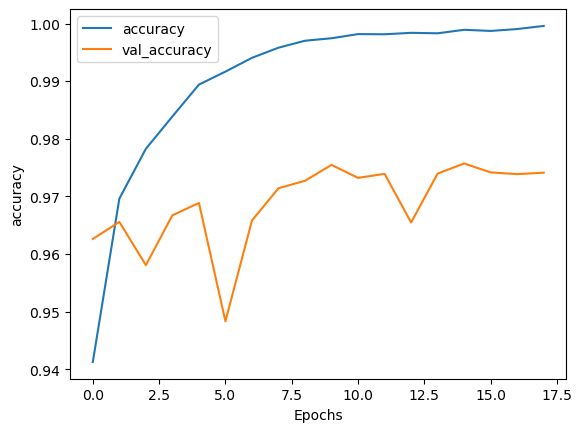

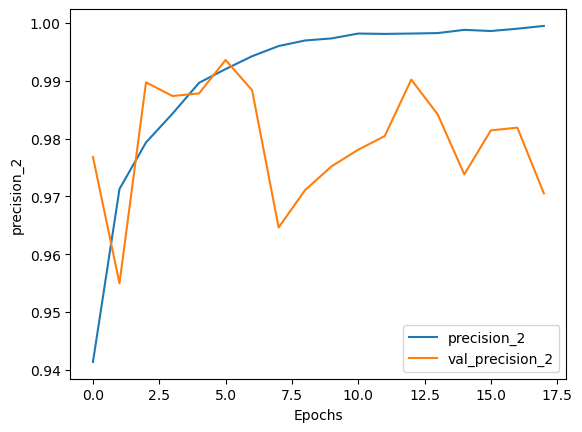

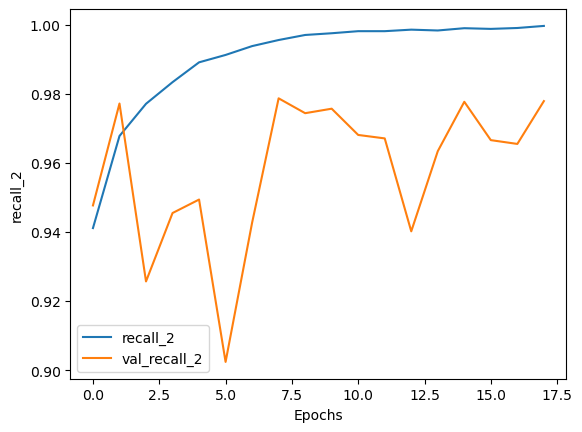

In [54]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

In [61]:
# Save the EfficientNet model
EfficientNet_model.save("EfficientNet_model.h5")

In [55]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()


4334752/4334752 [==============================] - 0s 0us/step

Model: "model_3"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 MobilenetV3small (Functiona  (None, 576)              939120    

 l)                                                              

                                                                 

 batch_normalization_3 (Batc  (None, 576)              2304      

 hNormalization)                                                 

                                                                 

 dense_9 (Dense)             (None, 256)               147712    

                                                                 

 dropout_3 (Dropout)         (None, 256)               0         

                                             

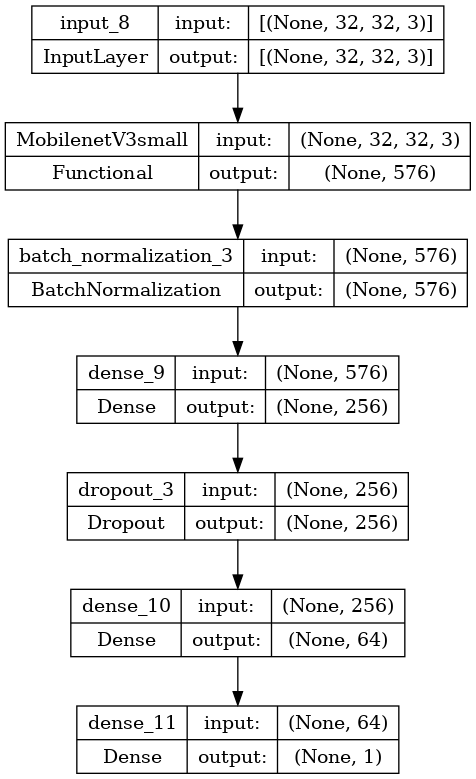

In [56]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [57]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...

Epoch 1/100

200/200 [==============================] - 75s 214ms/step - loss: 1.0924 - accuracy: 0.8752 - precision_1: 0.8654 - recall_1: 0.8888 - val_loss: 1.4240 - val_accuracy: 0.6321 - val_precision_1: 0.5761 - val_recall_1: 0.9998

Epoch 2/100

200/200 [==============================] - 40s 195ms/step - loss: 0.1894 - accuracy: 0.9375 - precision_1: 0.9371 - recall_1: 0.9379 - val_loss: 0.1814 - val_accuracy: 0.9389 - val_precision_1: 0.9201 - val_recall_1: 0.9613

Epoch 3/100

200/200 [==============================] - 41s 198ms/step - loss: 0.1538 - accuracy: 0.9481 - precision_1: 0.9483 - recall_1: 0.9479 - val_loss: 0.1721 - val_accuracy: 0.9408 - val_precision_1: 0.9659 - val_recall_1: 0.9138

Epoch 4/100

200/200 [==============================] - 40s 196ms/step - loss: 0.9338 - accuracy: 0.8417 - precision_1: 0.8537 - recall_1: 0.8249 - val_loss: 3.2487 - val_accuracy: 0.5000 - val_precision_1: 0.0000e+00 - val_r

In [58]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 4s 83ms/step - loss: 0.1721 - accuracy: 0.9408 - precision_3: 0.9659 - recall_3: 0.9138

Val Loss: 0.1721

Val Accuracy: 0.9408

Val Precision: 0.9659

Val Recall: 0.9138


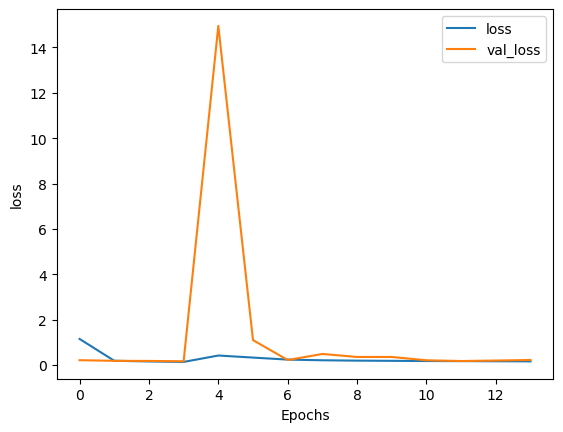

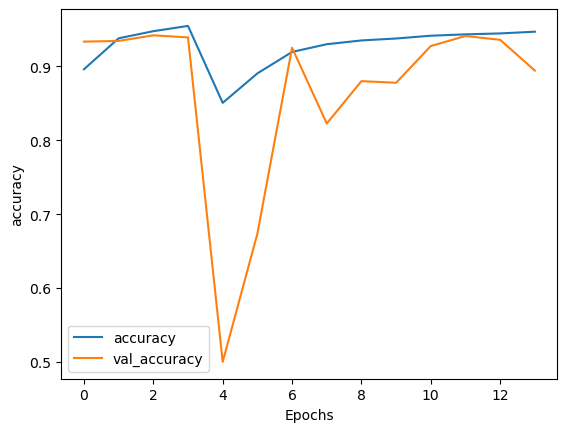

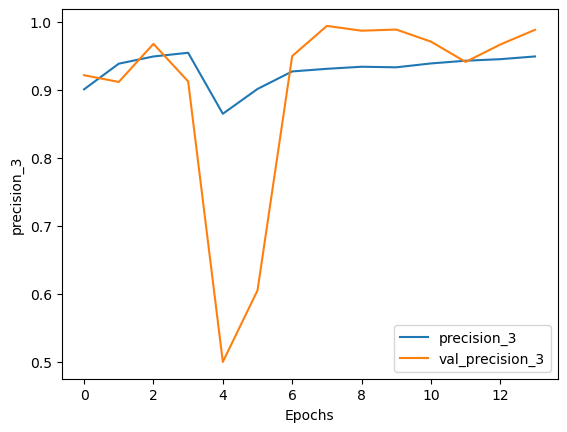

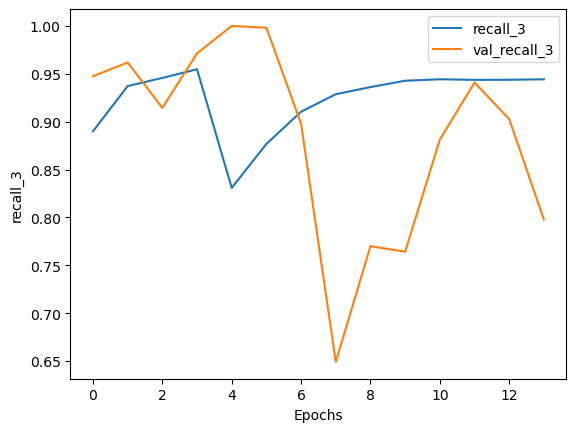

In [60]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [62]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5")

The model with EfficientNet as the base is the clear winner with the best performance in all the metrics combined; however, MobileNet is also a great option since its model size is significantly lower than EfficientNet's, with a minor decrease in performance.